# XAI: Chapter 1 - Introduction

Michael Mayer

# Introduction

Welcome to the part "XAI" (e**X**plainable **A**rtificial **I**ntelligence) of the lecture "Responsible Machine Learning with Insurance Applications". 

The basic question of XAI is:

> How to explain and interpret a given model, even if it seems a black box?

Answering this question is a key aspect of responsible machine learning (ML). It not only provides valuable information and knowledge for stakeholders, but also helps to identify problems in the modeling process.

# Scope and Taxonomy

Thanks to the rise of ML and the desire to explain its models, the field of explainable ML is developing rapidly. We will study the most important methods for *structured data*. Unstructured data (images, audio sequences, text, ...) often has its own specialized explanation tools. Covering them is beyond the scope of this lecture.

The following taxonomy of explainability methods is often helpful, see Molnar (<a href="#ref-molnar2019">2019</a>) for more background:

- *Global versus local explainability:* Global explainability methods describe the model as a whole, while local methods focus on explaining model behavior around a single observation. We will mainly cover global methods, with one notable exception (SHAP).
- *Model-specific versus model-agnostic:* Each modeling technique typically has its own tailored methods for interpretation. For example, a linear regression can be explained by examining its coefficients. Tree-based models are another example: The variable importance of a feature in such a model can be assessed, for instance, by studying the average loss reduction from splits on that feature. In contrast to such model-specific methods, a model-agnostic method is suitable for all types of models. Our focus is on model-agnostic techniques, although we sometimes show model-specific methods for comparison.
- *Intrinsic versus post-hoc*: The simple structure of a linear model, an additive model, or a short decision tree makes such modeling techniques intrinsically interpretable. In contrast, models with complex structure (e.g., a neural net) are interpretable only by post-hoc analysis of the fitted model. Model-agnostic interpretability methods are always used for post-hoc explainability. However, they can also be applied to an intrinsically interpretable model.

Note: We will use the terms "explainable", "interpretable", and "intelligible" interchangeably, although subtle differences are sometimes pointed out in the literature. 

# Outline

This chapter introduces important notations, the necessary background on non-life insurance pricing, and the main example that will guide us on our way through the illuminating world of model explainability.

In the chapter "Explaining Models" we will learn the most important methods of post-hoc interpretability. We will also learn how to use the insights gained from interpreting complex models to improve linear models.

The third chapter, "Improving Explainability", takes a different path. Here we explore ways to improve the intrinsic explainability of complex models by simplifying their internal structure, in particular by forcing parts of the model to be additive and/or monotonic.

# Notation

Throughout the XAI notebooks, we consider a typical modeling situation: a distributional property $T$ of a real-valued response variable $Y$ should be approximated by a model $m: \boldsymbol x \in \mathbb R^p \mapsto \mathbb R$ of a $p$-dimensional feature vector $\boldsymbol X = (X^{(1)}, \dots, X^{(p)})$ with value $\boldsymbol x = (x^{(1)}, \dots, x^{(p)}) \in \mathbb R^p$, i.e.,
$$
  T(Y\mid \boldsymbol X = \boldsymbol x) \approx m(\boldsymbol x).
$$
For brevity, we write $T(Y\mid \boldsymbol X = \boldsymbol x) = T(Y\mid \boldsymbol x)$.

Examples of $T$ are the expectation $T =\mathbb E$, or a quantile $q_\alpha$. The model $m$ is then estimated by $\hat m$ from the training data by minimizing some objective criterion typically of the form
$$
  \frac{1}{\sum_{i = 1}^n w_i} \sum_{i = 1}^n w_i L(\hat y_i, y_i) + \lambda \Omega(m),
$$
where

- $L$ is a loss function (sometimes called "scoring function") ideally strictly consistent for $T$, e.g., the squared error $L(z, y) = (y - z)^2$,
- $1 \le i \le n$ are the observations in the dataset considered,
- $\lambda \Omega(m)$ is an optional penalty to reduce overfitting,
- $\boldsymbol w = (w_1, \dots, w_n)^T$ is the vector of (optional) non-negative case weights of the $n$ observations ($w_i = 1$ if there are no such case weights),
- $\boldsymbol y = (y_1, \dots, y_n)^T$ are the $n$ observed values of $Y$,
- $\boldsymbol{\hat y} = (\hat y_1, \dots, \hat y_n)^T$ is the vector of predicted or fitted values, i.e., $\hat y_i = \hat m(\boldsymbol x_i)$,
- $\boldsymbol x_1, \dots, \boldsymbol x_n$ are the feature vectors corresponding to the $n$ observations. Consequently, $x_i^{(j)}$ denotes the value of the $j$-th feature of the $i$-th observation.

Even if many of the concepts covered in this lecture also work for classification settings with more than two classes, we focus on regression and binary classification. 

Some additional notation is introduced in the following examples of important model classes.

## Example: Linear regression

The model equation of a linear regression model is assumed to satisfy
$$
  \mathbb E(Y \mid \boldsymbol x) = m(\boldsymbol x) = \beta_o + \beta_1 x^{(1)} + \dots + \beta_p x^{(p)},
$$
where $(\beta_o, \beta_1, \dots, \beta_p) \in \mathbb R^{p+1}$ is the parameter vector to be estimated by minimizing the sum of squared errors
$$
  \sum_{i = 1}^n (y_i - \hat y_i)^2
$$
by linear least-squares.

## Example: Generalized linear model (GLM)

The model equation of a generalized linear model (<a href="#ref-nelder1972">Nelder and Wedderburn 1972</a>) with link function $g$ and inverse link $g^{-1}$ is assumed to satisfy:
$$
  \mathbb E(Y \mid \boldsymbol x) = m(\boldsymbol x) = g^{-1}(\eta(\boldsymbol x)) = g^{-1}(\beta_o + \beta_1 x^{(1)} + \dots + \beta_p x^{(p)}),
$$
where the linear part $\eta$ of the model is called the *linear predictor*. The parameters $\beta_j$ are estimated by minimizing the (possibly weighted) average deviance $\bar S$, a measure depending on the distribution assumed for $Y\mid \boldsymbol x$. Typical distributions are the Poisson distribution, the Gamma distribution, the Bernoulli distribution, and the normal distribution. 

In this lecture, we will often model insurance claim counts by a Poisson GLM with log link $g$. Its (possibly weighted) average deviance on the training data $D_{\text{train}} = \{(y_i, w_i, \boldsymbol x_i), i = 1, \dots, n\}$ is given by the formula
$$
   \bar S(\hat m, D_{\text{train}}) = \sum_{i = 1}^n w_i S(\hat y_i, y_i) / \sum_{i = 1}^n w_i,
$$
where $S$ is the (unit) Poisson deviance of a single observation,
$$
  S(\hat y_i, y_i) = 2(y_i \log(y_i / \hat y_i) - (y_i - \hat y_i)).
$$

## Example: Generalized additive model (GAM)

An important extension of the GLM is the generalized additive model (<a href="#ref-hastie1986">Hastie and Tibshirani
1986</a>, <a href="#ref-hastie1990">1990</a>; <a href="#ref-wood2017">Wood 2017</a>). Its model equation is assumed to satisfy
$$
  \mathbb E(Y \mid \boldsymbol x) = m(\boldsymbol x) = g^{-1}(\beta_o + f_1(x^{(1)}) + \dots + f_p(x^{(p)}))
$$
for sufficiently nice functions $f_j$ describing the Ceteris Paribus effect of feature $X^{(j)}$ on $g(\mathbb E(Y \mid \boldsymbol x))$, and $\beta_o$ is the intercept.
As functions $f_j$, often penalized regression smooths are used that are then being estimated to minimize the distribution specific average deviance. The functions $f_j$ are usually zero-centered to uniquely define them. Some of the components $f_j$ can also be fully parametric, just like in a GLM.

GAMs and GLMs can also contain interaction terms, i.e., components that depend on more than one covariate.

## Example: Gradient boosted decision trees (GBDT)

Like a neural net, gradient boosted trees (<a href="#ref-friedman2001">Friedman 2001</a>) allow to represent extremely flexible model equations. They can automatically pick up complex interactions between covariates, a process that would need to be done in a manual way for linear models. Such models are fitted by applying gradient boosting on the objective function chosen in line with $T$. 

Different implementation of gradient boosting exist. We will mainly work with XGBoost (<a href="#ref-chen2016">Chen and Guestrin
2016</a>) and LightGBM (<a href="#ref-ke2017">Ke et al. 2017</a>). They allow to model different functionals $T$, and offer a rich set of objective functions and many regularization parameters. We will, as a competitor of the Poisson GLM and the Poisson GAM, also consider Poisson boosted trees.

For details on gradient boosting, check our corresponding lecture slides, and also [this section](https://mayer79.github.io/statistical_computing_material/5_Trees.html#4_Gradient_Boosted_Trees) of "Statistical Computing".

# Non-Life Insurance Pricing

The models described above are highly relevant in insurance pricing. A brief description of this field is given here.

One of the main tasks of a non-life pricing actuary is to predict the *pure premium* associated with an insurance policy. It is defined as the financial loss per year or per some other relevant exposure measure.
The insurance company uses this information to optimize its tariffs and to estimate expected future profit. Such predictions are usually made by statistical models based on historical data on policies and claims.

Slightly adapting the notation of Wüthrich and Buser (<a href="#ref-wuethrich2021">2021</a>), we use the following terms to characterize an insurance policy with exposure $w$. Throughout these notebooks, $w$ is measured in yearly units.

- $w > 0$: The exposure. All other quantities will refer to this.
- $N$: Number of claims. 
- $C$: Total claim amount.
- $C / w$: Pure premium.
- $Y = N / w$: The claims frequency, i.e., the number of claims per exposure.
- $Z = C / N$: The claims severity, i.e., the average cost per claim (undefined if $N = 0$).
- $\boldsymbol X$: One or more risk characteristics describing the policy.

Observed values for two fictive motor third-part liability (MTPL) policies could look like this:

| id | $w$ | $N$ | $C$  | $C/w$ | $Y$ | $Z$  | Driver's age | Horse power |
|:--:|:---:|:---:|:----:|:-----:|:---:|:----:|:------------:|:-----------:|
| 1  | 1   | 0   | 0    | 0     | 0   | -    | 28           | 80          |
| 2  | 0.5 | 2   | 5000 | 10000 | 4   | 2500 | 20           | 250         |
| 2  | 0.5 | 1   | 1000 | 2000  | 2   | 1000 | 21           | 250         |

Due to the additivity of $w$, $N$, and $C$, these quantities can also be defined for multiple policies together, e.g., for the entire portfolio.

Instead of directly modeling $\mathbb E(C / w \mid \boldsymbol x)$, pricing actuaries often decompose the pure premium into a product of frequency and severity 
$$
  C / w = (C / w) \cdot (N / N) = (N / w) \cdot (C / N) = Y  Z
$$ 
and derive two models: One for the claims frequency
$$
  \mathbb E(Y \mid \boldsymbol x) \approx m_Y(\boldsymbol x),
$$
classically a Poisson GLM with log link and case weights $w$; and another one for the severity
$$
  \mathbb E(Z \mid \boldsymbol x) \approx m_Z(\boldsymbol x),
$$
classically a Gamma GLM with log link and case weights $N$, using only rows with $N>0$.

Assuming conditional independence of $Y$ and $Z$, the combined model for the pure premium is then given by the product of the two models, i.e., by 
$$
  \mathbb E(C / w \mid \boldsymbol x) \approx m_Y(\boldsymbol x)  m_Z(\boldsymbol x).
$$
The GLMs can be replaced by corresponding GAMs or modern ML techniques like deep learning and boosted trees. These alternatives are ideally fitted using the same loss functions (the corresponding deviance), the same case weights, and also using log links.

For more information on non-life insurance pricing, we recommend the excellent references Wüthrich and Buser (<a href="#ref-wuethrich2021">2021</a>) and Ohlsson and Johansson (<a href="#ref-ohlsson2015">2015</a>). 

## Further remarks

- The two models can use different feature sets.
- The severity model uses a log link to ensure a multiplicative model structure on the response scale. Since the logarithm is not the natural link function of the Gamma GLM, this leads to a slight bias on the scale of the response, which can be eliminated, e.g., by applying an empirical multiplicative correction factor (calculated on the training data)
$$
  c = \sum_{i = 1}^n y_i / \sum_{i = 1}^n \hat y_i.
$$
- Instead of fitting a Poisson model for claims frequency using case weights $w$, one can alternatively model the claim counts $N$ by a Poisson model without case weights but using an offset of $\log(w)$. Such a model will predict expected claim counts rather than expected claim frequencies. Nevertheless, the estimated coefficients will be identical between the two variants.

# Main Example

We will work with the French motor third-part liability (MTPL) dataset available on [openML (ID 41214)](https://www.openml.org/d/41214) to model claims frequency.

## Software

Python 3.11 with environment specified in "requirements.txt".

## The data

The first code snippets of this notebook perform the following steps:

- The dataset is downloaded from OpenML.
- Rows with identical risk factors ("Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region") are assigned to a "group_id". We assume that rows in such a group represent the same policy, even if their "IDpol" varies. This seems to be a curious property of this dataset. As we will see later, working with grouped data is a tricky business, and ignoring grouping can lead to biased results.
- Certain transformations are applied. For instance, very large feature values are truncated and small categories are collapsed to one category.
- The column names of the features are stored for later use.
- All relevant columns are described univariately, some also bivariately.

If you need a refresher on Python, I recommend the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) of Jake VanderPlas (<a href="#ref-vanderplas">2016</a>).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, SplineTransformer
from utils import get_coefs  # from utils.py

df_original = fetch_openml(data_id=41214, parser="pandas").frame
df_original

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


In [2]:
# Will use these columns to identify rows that might belong to same policy
xgrp = [
    "Area",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "VehBrand",
    "VehGas",
    "Density",
    "Region",
]

df = (
    df_original.assign(
        group_id=lambda x: x.groupby(xgrp, observed=True).ngroup(),
        Exposure=lambda x: x.Exposure.clip(upper=1),
        Freq=lambda x: (x.ClaimNb / x.Exposure).clip(upper=15),
        VehPower=lambda x: x.VehPower.clip(upper=12),
        VehAge=lambda x: x.VehAge.clip(upper=20),
        VehGas=lambda x: (x.VehGas == "'Diesel'").astype(int),
        DrivAge=lambda x: x.DrivAge.clip(upper=85),
        logDensity=lambda x: np.log(x.Density),
        PolicyRegion=lambda x: x.Region.cat.set_categories(  # Lump small levels
            ["R24", "R11", "R53", "R82", "R93", "Other"]
        ).fillna("Other"),
        VehBrand=lambda x: x.VehBrand.cat.set_categories(
            ["B12", "B1", "B2", "Other"]
        ).fillna("Other"),
    )
    .sort_values(["group_id"])
    .reset_index(drop=True)
)

In [3]:
# Covariates
x_num = ["VehPower", "VehAge", "VehGas", "DrivAge", "logDensity"]
x_cat = ["VehBrand", "PolicyRegion"]
xvars = x_num + x_cat

# Some statistics
print("Data shape:", df.shape)
print(f"Total exposure: {df.Exposure.sum():n}")
print("Number of claims:", df.ClaimNb.sum())
print("Frequency:", (df.ClaimNb.sum() / df.Exposure.sum()).round(3))

print("\nTop rows of relevant columns:")
df[["IDpol", "group_id", "ClaimNb", "Freq", "Exposure", *xvars]].head(8)

Data shape: (678013, 16)
Total exposure: 358360
Number of claims: 36102
Frequency: 0.101

Top rows of relevant columns:


,IDpol,group_id,ClaimNb,Freq,Exposure,VehPower,VehAge,VehGas,DrivAge,logDensity,VehBrand,PolicyRegion
0,5109583.0,0,0,0.0,0.02,4,0,0,18,3.871201,B12,Other
1,107133.0,1,0,0.0,0.41,4,0,1,19,3.871201,Other,Other
2,5107816.0,2,0,0.0,0.06,4,0,0,19,3.332205,B12,Other
3,5107815.0,2,0,0.0,0.03,4,0,0,19,3.332205,B12,Other
4,107132.0,3,0,0.0,0.31,4,0,1,19,3.871201,Other,Other
5,4063569.0,4,0,0.0,0.18,4,0,1,19,2.995732,B12,Other
6,4063568.0,4,0,0.0,0.02,4,0,1,19,2.995732,B12,Other
7,4063566.0,4,0,0.0,0.03,4,0,1,19,2.995732,B12,Other


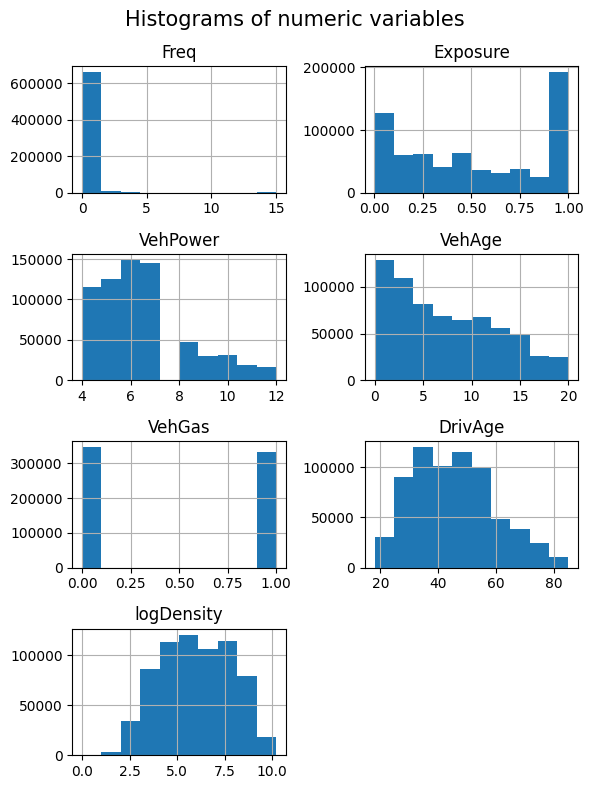

In [4]:
df[["Freq", "Exposure", *x_num]].hist(figsize=(6, 8), layout=(4, 2))
plt.suptitle("Histograms of numeric variables", fontsize=15)
plt.tight_layout()

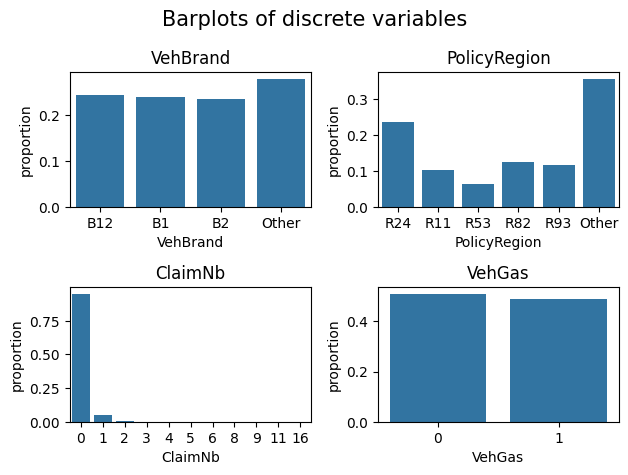

In [5]:
fig, axes = plt.subplots(2, 2)
fig.suptitle("Barplots of discrete variables", fontsize=15)

for x, ax in zip([*x_cat, "ClaimNb", "VehGas"], axes.flatten()):
    sns.countplot(data=df, x=x, stat="proportion", ax=ax).set_title(x)
fig.tight_layout()

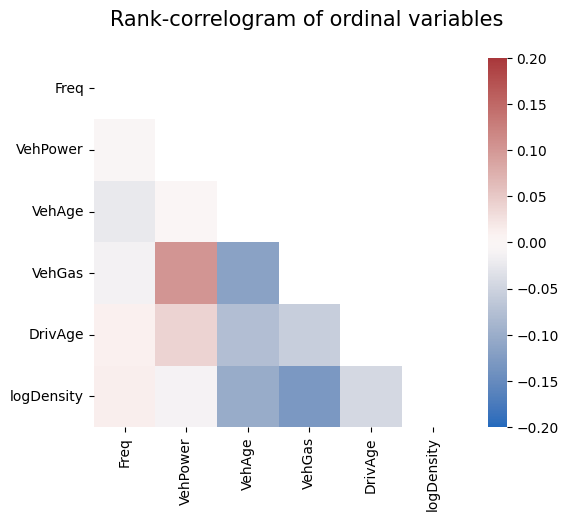

In [6]:
corr = df[["Freq", *x_num]].corr("spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.suptitle("Rank-correlogram of ordinal variables", fontsize=15)
_ = sns.heatmap(
    corr, mask=mask, vmin=-0.2, vmax=0.2, center=0, cmap="vlag", square=True
)

**Comments:** 

- The dataset has about 680k observations.
- The univariate distributions of the variables in the prepared dataset look plausible.
- Rank-correlations are weak.
- Rows 2 and 3 share the same "group_id", as do rows 5, 6, and 7. Not only are all of their risk factors identical, but their "IDpol" are very similar as well. This increases confidence in our proxy "group_id".

## The models

We will now calculate three models: 

1. An additive Poisson GLM fitted by Scikit-Learn's `PoissonRegressor()`, a
2. Poisson GAM with several splines (also via `PoissonRegressor()`), and a
3. Poisson boosted trees model with implicit log link fitted by LightGBM (<a href="#ref-ke2017">Ke et al. 2017</a>) and tuned with grouped five-fold cross-validation. 

The models are calculated on about 80% of the observations, while the rest is kept for model validation. Since we suspect that some policies are represented by multiple rows, the data split is done in a grouped way, assigning all rows with the same "group_id" to either the training or the test dataset. That logic was also applied to create the cross-validation folds for selecting or *tuning* the hyperparameters of the LightGBM model. More about grouped splits will follow in Chapter 2.

In [7]:
# Grouped train/test split
group_splitter = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=836)
train_indices, test_indices = next(group_splitter.split(X=df, groups=df.group_id))
train, test = df.iloc[train_indices, :], df.iloc[test_indices, :]
train = train.sample(frac=1, random_state=84)  # remove sort order, e.g. for neural nets

print("Training size:", len(train))
print("Test size:", len(test))

Training size: 542562
Test size: 135451


In [8]:
# X, y, w
X_train, X_test = train[xvars], test[xvars]
y_train, y_test = train["Freq"].to_numpy(), test["Freq"].to_numpy()
w_train, w_test = train["Exposure"].to_numpy(), test["Exposure"].to_numpy()

### GLM

In [9]:
# Dummy encoding in logical order
cat_levels = [train[v].cat.categories.to_list() for v in x_cat]
ohe = OneHotEncoder(categories=cat_levels, drop="first", sparse_output=False)
prep_glm = ColumnTransformer(
    [("num", "passthrough", x_num), ("cat", ohe, x_cat)],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

model_glm = Pipeline(
    [
        ("preprocessor", prep_glm),
        ("model", PoissonRegressor(alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train, model__sample_weight=w_train)

get_coefs(model_glm[-1])  # from utils.py

,Estimates
VehPower,0.002623
VehAge,-0.033077
VehGas,-0.055646
DrivAge,-0.005083
logDensity,0.063500
VehBrand_B1,-0.145381
VehBrand_B2,-0.136302
VehBrand_Other,-0.151407
PolicyRegion_R11,-0.055865
PolicyRegion_R53,-0.008607


### GAM

We will now fit a GLM with some splines.

In [10]:
spline_7_knots, spline_3_knots = (
    SplineTransformer(n_knots=m, knots="quantile", include_bias=False) for m in (7, 3)
)
prep_gam = ColumnTransformer(
    [
        ("ages", spline_7_knots, ["VehAge", "DrivAge"]),
        ("logDensity", spline_3_knots, ["logDensity"]),
        ("linear", "passthrough", ["VehPower", "VehGas"]),
        ("cat", ohe, x_cat),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

model_gam = Pipeline(
    [
        ("preprocessor", prep_gam),
        ("model", PoissonRegressor(alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train, model__sample_weight=w_train)

print("Some coefficients:")
get_coefs(model_gam[-1]).tail(10)

Some coefficients:


,Estimates
VehPower,0.005851
VehGas,-0.034896
VehBrand_B1,-0.119619
VehBrand_B2,-0.127386
VehBrand_Other,-0.125723
PolicyRegion_R11,-0.024539
PolicyRegion_R53,0.016120
PolicyRegion_R82,0.042560
PolicyRegion_R93,-0.058980
PolicyRegion_Other,-0.091776


In [11]:
# Visualize additive components: Take observation and follow its prediction when
# sliding a feature over its range
def additive_component(v, X, model, log_scale=False):
    """Returns (x, y) coord of additive components to plot."""

    x = sorted(X[v].unique())
    X_plot = X.iloc[np.zeros_like(x), :]
    X_plot.loc[:, v] = x
    y = model.predict(X_plot)
    if log_scale:
        y = np.log(y)
    return (x, y)

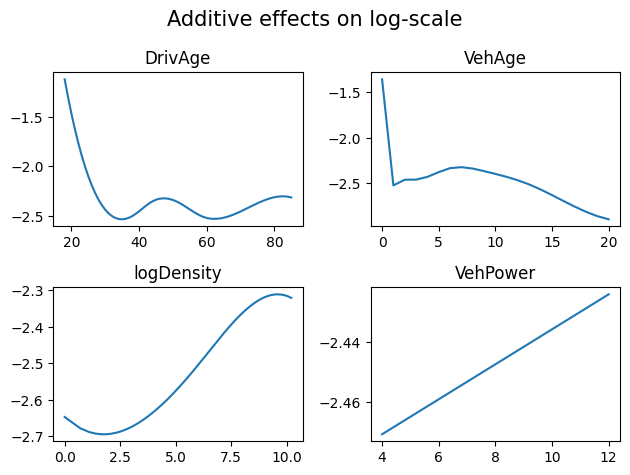

In [12]:
fig, axes = plt.subplots(2, 2)
fig.suptitle("Additive effects on log-scale", fontsize=15)

for x, ax in zip(["DrivAge", "VehAge", "logDensity", "VehPower"], axes.flatten()):
    points = additive_component(x, X=X_train, model=model_gam, log_scale=True)
    ax.plot(*points)
    ax.set_title(x)
fig.tight_layout()

### Boosted Trees

In [13]:
# Integer encode categoricals (only necessary for SHAP, see later)
prep_lgb = ColumnTransformer(
    [
        ("num", "passthrough", x_num),
        ("cat", OrdinalEncoder(categories=cat_levels), x_cat),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# See "Chapter 3: Excursion: Tuning Boosted Trees" how these values have been found
boosting_rounds = 209
params = {
    "objective": "poisson",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "reg_lambda": 5,
    "reg_alpha": 0,
    "colsample_bynode": 0.8,
    "subsample": 1,
    "min_child_samples": 50,
    "poisson_max_delta_step": 0.7,
    "verbose": -1,
}

lgbr = LGBMRegressor(
    **params, n_estimators=boosting_rounds, importance_type="gain", random_state=59
)

model_lgb = Pipeline([("preprocessor", prep_lgb), ("model", lgbr)])
_ = model_lgb.fit(X=X_train, y=y_train, model__sample_weight=w_train)

Save models and data pieces:

In [14]:
main = Path("french_motor")

# Things needed for modeling
dump(
    (train, test, X_train, X_test, y_train, y_test, w_train, w_test, xvars, prep_lgb),
    main / "data.joblib",
)

# The models
dump((model_glm, model_gam, model_lgb), main / "models.joblib")

['french_motor\\models.joblib']

**Comments:** 

- Fitting models on 540k rows is fast.
- The code for selecting the hyperparameters of the boosted trees model (see Chapter 3) is long but very general, so that only minor adaptions need to be made for other modeling situations.
- The GLM can directly be interpreted from its output. For example, a one-point increase in "DrivAge" is associated with a change in log expected claims frequency of $-0.0051$. On the frequency scale, this corresponds to a change of $100\% \cdot (e^{-0.0051} - 1) \approx -0.5\%$. 
- The GAM shows strong non-linear effects. They can be visualized by selecting any observation and then calculating the predictions for different feature values.

What about feature effects in the Boosted Trees model? What features are the most important? It will be the goal of the next chapter to answer such questions with tools from XAI.

# Exercises

Here, we will work with an Australian car claims dataset "dataCar" from the R package {insuranceData}, and stored as "australian_car/dataCar.parquet". You can use the following code as a guide and starting point for solving the exercises.

In [15]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from utils import get_coefs  # utils.py

from xgboost import XGBRegressor

main = Path("australian_car")
df0 = pd.read_parquet(main / "dataCar.parquet")

df = df0.assign(
    Freq=lambda x: x.numclaims / x.exposure,
    Sev=lambda x: x.claimcst0 / x.numclaims,
    veh_body=lambda x: x.veh_body.cat.set_categories(
        ["HBACK", "SEDAN", "STNWG", "Other"]
    ).fillna("Other"),
    log_value=lambda x: np.log(x.veh_value.clip(0.3, 15)),
)

# Features
xvars = ["log_value", "agecat", "veh_age", "area", "veh_body", "gender"]

# XGBoost parameters for the last exercise
boosting_rounds = 292
params = {
    "objective": "count:poisson",
    "learning_rate": 0.05,
    "max_depth": 2,
    "reg_lambda": 2,
    "reg_alpha": 1,
    "colsample_bynode": 0.8,
    "subsample": 1,
    "min_split_loss": 0.001,
    "max_delta_step": 0.1,
}

df

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,Freq,Sev,log_value
0,1.06,0.303901,0,0,0.000000,HBACK,3,F,C,2,0.000000,NaN,0.058269
1,1.03,0.648871,0,0,0.000000,HBACK,2,F,A,4,0.000000,NaN,0.029559
2,3.26,0.569473,0,0,0.000000,Other,2,F,E,2,0.000000,NaN,1.181727
3,4.14,0.317591,0,0,0.000000,STNWG,2,F,D,2,0.000000,NaN,1.420696
4,0.72,0.648871,0,0,0.000000,HBACK,4,F,C,2,0.000000,NaN,-0.328504
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67851,1.07,0.654346,0,0,0.000000,SEDAN,2,M,A,6,0.000000,NaN,0.067659
67852,1.23,0.908966,0,0,0.000000,SEDAN,4,M,C,3,0.000000,NaN,0.207014
67853,1.93,0.312115,0,0,0.000000,STNWG,4,M,C,3,0.000000,NaN,0.657520
67854,0.97,0.320329,1,1,7646.769989,HBACK,3,F,C,2,3.121795,7646.769989,-0.030459


1. Descriptive Analysis
    - i. Check "dataCar.md" (located beside the Parquet data file) for the definition of the columns.
    - ii. Calculate relevant statistics at portfolio level, i.e., on the full dataset: Total and average exposure, total claim amount, number of claims, pure premium, frequency, and severity.
    - iii. Describe the distribution of each model feature in `xvars` in the prepared dataset. Use tables and/or plots and/or text.

2. Modeling: Next, we develop different claims frequency models using the same set of features (`xvars`).
    - i. Split the dataset into 80% for training and 20% for testing. Don't touch the test data during modeling.
    - ii. GLM: Fit an exposure-weighted Poisson GLM with log link to the claim frequencies. (Treat the numerically encoded variables "agecat", "veh_age" as categoricals, too.) Interpret the estimated coefficients of the features "log_value" and "gender".
    - iii. Random forest: Model "Freq" by an exposure-weighted random forest using Poisson loss. Select the optimal tree depth by minimizing exposure-weighted Poisson deviance calculated from the out-of-bag (OOB) predictions on the training data. How are OOB predictions being calculated?
    - iv. XGBoost: Study the documentation of [XGBoost](https://xgboost.readthedocs.io/en/stable/). The original publication is Chen and Guestrin (<a href="#ref-chen2016">2016</a>), and a fantastic slide deck (pdf) of the author can be found on this [Link](https://web.njit.edu/~usman/courses/cs675_fall16/BoostedTree.pdf). Use the {xgboost} library to fit an exposure-weighted Poisson XGBoost model with the hyperparameters stated in the code above. We will later see *how* to find such parameters. Note that XGBoost automatically uses a log link when fitting a Poisson model.

# References

<div id="ref-chen2016" class="csl-entry">
Chen, Tianqi, and Carlos Guestrin. 2016. <span>“XGBoost: A Scalable Tree
Boosting System.”</span> In <em>Proceedings of the 22nd ACM SIGKDD
International Conference on Knowledge Discovery and Data Mining</em>,
785–94. KDD ’16. New York, NY, USA: Association for Computing Machinery.
<a href="https://doi.org/10.1145/2939672.2939785">https://doi.org/10.1145/2939672.2939785</a>.
</div>

<br>
<div id="ref-friedman2001" class="csl-entry">
Friedman, Jerome H. 2001. <span>“Greedy Function Approximation: A
Gradient Boosting Machine.”</span> <em>Ann. Stat.</em> 29 (5):
1189–1232. <a href="https://doi.org/10.1214/aos/1013203451">https://doi.org/10.1214/aos/1013203451</a>.
</div>

<br>
<div id="ref-hastie1986" class="csl-entry">
Hastie, Trevor, and Robert Tibshirani. 1986. <span>“<span>Generalized
Additive Models</span>.”</span> <em>Stat. Sci.</em> 1 (3): 297–310. <a href="https://doi.org/10.1214/ss/1177013604">https://doi.org/10.1214/ss/1177013604</a>.
</div>
<div id="ref-hastie1990" class="csl-entry">
———. 1990. <em>Generalized Additive Models</em>. Wiley Online Library.
</div>

<br>
<div id="ref-ke2017" class="csl-entry">
Ke, Guolin, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma,
Qiwei Ye, and Tie-Yan Liu. 2017. <span>“LightGBM: A Highly Efficient
Gradient Boosting Decision Tree.”</span> In <em>Advances in Neural
Information Processing Systems</em>, 30:3149–57. Curran Associates, Inc.
</div>

<br>
<div id="ref-molnar2019" class="csl-entry">
Molnar, Christoph. 2019. <em>Interpretable Machine Learning: A Guide for
Making Black Box Models Explainable</em>. <a href="https://christophm.github.io/interpretable-ml-book" class="uri">https://christophm.github.io/interpretable-ml-book</a>.
</div>

<br>
<div id="ref-nelder1972" class="csl-entry">
Nelder, J. A., and R. W. M. Wedderburn. 1972. <span>“Generalized Linear
Models.”</span> <em>J. R. Stat. Soc. Series A (General)</em> 135 (3):
370–84. <a href="https://doi.org/10.2307/2344614">https://doi.org/10.2307/2344614</a>.
</div>

<br>
<div id="ref-ohlsson2015" class="csl-entry">
Ohlsson, E., and B. Johansson. 2015. <em>Non-Life Insurance Pricing with
Generalized Linear Models</em>. EAA Series. Springer Berlin Heidelberg.
</div>

<br>
<div id="ref-vanderplas2016" class="csl-entry">
VanderPlas, Jake. 2016. <em>Python Data Science Handbook : Essential
Tools for Working with Data</em>. O’Reilly Media, Inc.
</div>

<br>
<div id="ref-wood2017" class="csl-entry">
Wood, Simon N. 2017. <em>Generalized Additive Models: An Introduction
with <span>R</span></em>. 2nd ed. United States: CRC Press. <a href="https://doi.org/10.1201/9781315370279">https://doi.org/10.1201/9781315370279</a>.
</div>

<br>
<div id="ref-wuethrich2021" class="csl-entry">
Wüthrich, Mario V., and Christoph Buser. 2021. <span>“Data Analytics for
Non-Life Insurance Pricing.”</span> <a href="https://doi.org/10.2139/ssrn.2870308">https://doi.org/10.2139/ssrn.2870308</a>.
</div>